# Pytorch 常用代码汇总
* 参考地址：https://zhuanlan.zhihu.com/p/59205847 </br>
* 官方github例子：https://github.com/pytorch/examples </br>
* 官方文档：https://pytorch.org/docs/stable/index.html </br>
* 官方论坛：https://discuss.pytorch.org/latest?order=views </br>

In [26]:
import numpy as np
import torch

## 1、基础配置

In [ ]:
# 1.1可复现性
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# 1.2显卡设置
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 如果需要指定多张显卡，比如0，1号显卡。
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

# 清除显存
torch.cuda.empty_cache()

# 重置GPU
nvidia-smi --gpu-reset -i [gpu_id]


## 2、张量处理
PyTorch有9种CPU张量类型和9种GPU张量类型。</br>
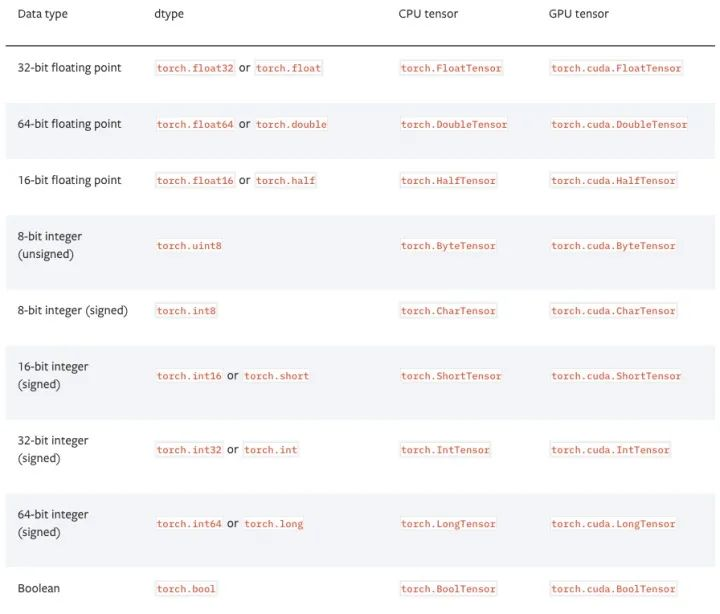

In [9]:
# 2.1张量基本信息
tensor = torch.randn(3,4,5)
print(tensor.type())  # 数据类型
print(tensor.size())  # 张量的shape，是个元组
print(tensor.dim())   # 维度的数量

torch.FloatTensor
torch.Size([3, 4, 5])
3


In [14]:
# 2.2命名张量

# 在PyTorch 1.3之前，需要使用注释
# Tensor[N, C, H, W]
images = torch.randn(32, 3, 56, 56)
images.sum(dim=1)
images.select(dim=1, index=0)

# PyTorch 1.3之后
NCHW = ['N', 'C', 'H', 'W']
images = torch.randn(32, 3, 56, 56, names=NCHW)
images.sum('C')
images.select('C', index=0)

# 也可以这么设置
tensor = torch.rand(3,4,1,2,names=('C', 'N', 'H', 'W'))

# 使用align_to可以对维度方便地排序
tensor = tensor.align_to('N', 'C', 'H', 'W')

In [ ]:
# 2.3数据类型转换
# 设置默认类型，pytorch中的FloatTensor远远快于DoubleTensor
torch.set_default_tensor_type(torch.FloatTensor)

# 2.3.1 类型转换
tensor = tensor.cuda()
tensor = tensor.cpu()
tensor = tensor.float()
tensor = tensor.long()


# 2.3.2 torch.Tensor与np.ndarray转换
ndarray = tensor.cpu().numpy()
tensor = torch.from_numpy(ndarray).float()
# np.ndarray执行了torch.Tensor没有的方法就会报错，使用.copy()创建副本之后不再共享内存。
tensor = torch.from_numpy(ndarray.copy()).float()


# 2.3.3 Torch.tensor与PIL.Image转换
# pytorch中的张量默认采用[N, C, H, W]的顺序，并且数据范围在[0,1]，需要进行转置和规范化
# torch.Tensor -> PIL.Image
# clamp（）函数的功能将输入input张量每个元素的值压缩到区间 [min,max]，并返回结果到一个新张量
image = PIL.Image.fromarray(torch.clamp(tensor*255, min=0, max=255).byte().permute(1,2,0).cpu().numpy())
image = torchvision.transforms.functional.to_pil_image(tensor)  # 等价方式

#  PIL.Image -> torch.Tensor
path = r'./figure.jpg'
tensor = torch.from_numpy(np.asarray(PIL.Image.open(path))).permute(2,0,1).float() / 255
tensor = torchvision.transforms.functional.to_tensor(PIL.Image.open(path)) # 等价方式


# 2.3.4 np.ndarray与PIL.Image的转换
image = PIL.Image.fromarray(ndarray.astype(np.uint8))
ndarray = np.asarray(PIL.Image.open(path))

In [ ]:
# 2.4 从只包含一个元素的张量中提取值
value = torch.rand(1).item()

In [ ]:
# 2.5 张量变形
# 在将卷积层输入全连接层的情况下通常需要对张量做形变处理，
# 相比torch.view，torch.reshape可以自动处理输入张量不连续的情况。
tensor = torch.rand(2,3,4)
shape = (6, 4)
tensor = torch.reshape(tensor, shape)
tensor.shape

In [ ]:
# 2.6 打乱顺序
tensor = tensor[torch.randperm(tensor.size(0))]  # 打乱第一个维度

In [ ]:
# 2.7 复制张量
# Operation                 |  New/Shared memory | Still in computation graph |
tensor.clone()            # |        New         |          Yes               |
tensor.detach()           # |      Shared        |          No                |
tensor.detach.clone()()   # |        New         |          No                |

In [ ]:
# 2.8 张量拼接
'''
注意torch.cat和torch.stack的区别在于torch.cat沿着给定的维度拼接，
而torch.stack会新增一维。例如当参数是3个10x5的张量，torch.cat的结果是30x5的张量，
而torch.stack的结果是3x10x5的张量。
'''
tensor = torch.cat(list_of_tensors, dim=0)
tensor = torch.stack(list_of_tensors, dim=0)

In [27]:
# 2.9 将整数标签转为one-hot编码
# pytorch的标记默认从0开始
tensor = torch.tensor([0, 2, 1, 3])
N = tensor.size(0)
num_classes = 4
one_hot = torch.zeros(N, num_classes).long()
one_hot.scatter_(dim=1, index=torch.unsqueeze(tensor, dim=1), src=torch.ones(N, num_classes).long())
one_hot

tensor([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])

In [ ]:
# 2.10 得到非零元素
torch.nonzero(tensor)               # index of non-zero elements
torch.nonzero(tensor==0)            # index of zero elements
torch.nonzero(tensor).size(0)       # number of non-zero elements
torch.nonzero(tensor == 0).size(0)  # number of zero elements

In [ ]:
# 2.11 判断两个张量相等
torch.allclose(tensor1, tensor2)  # float tensor
torch.equal(tensor1, tensor2)     # int tensor

In [ ]:
# 2.12 张量扩张
# Expand tensor of shape 64*512 to shape 64*512*7*7.
tensor = torch.rand(64,512)
torch.reshape(tensor, (64, 512, 1, 1)).expand(64, 512, 7, 7)

In [ ]:
# 2.13 矩阵扩张
# Matrix multiplcation: (m*n) * (n*p) * -> (m*p).
result = torch.mm(tensor1, tensor2)

# Batch matrix multiplication: (b*m*n) * (b*n*p) -> (b*m*p)
result = torch.bmm(tensor1, tensor2)

# Element-wise multiplication(两个矩阵对应位置元素进行乘积)
result = tensor1 * tensor2